In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.9  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("MountainCar-v0")  # Create the environment
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [2]:
num_inputs = 2
num_actions = 3
num_hidden = 64

inputs = layers.Input(shape=(num_inputs,))
# common = layers.Dense(num_hidden, activation="relu")(inputs)
# common_prec_prec = layers.Dense(round(num_hidden/2), activation="relu")(inputs)
# common_prec = layers.Dense(round(num_hidden/4), activation="relu")(common_prec_prec)
# common = layers.Dense(num_hidden, activation="relu")(inputs)
# common2 = layers.Dense(round(num_hidden/2), activation="relu")(common)

x = layers.Dense(num_hidden)(inputs)
x = layers.LeakyReLU()(x)
# x = layers.Dense(round(num_hidden/4))(x)
# x = layers.LeakyReLU()(x)
action = layers.Dense(num_actions, activation="softmax")(x)
critic = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=[action, critic])

2021-09-08 13:49:01.948947: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           192         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            195         leaky_re_lu[0][0]                
______________________________________________________________________________________________

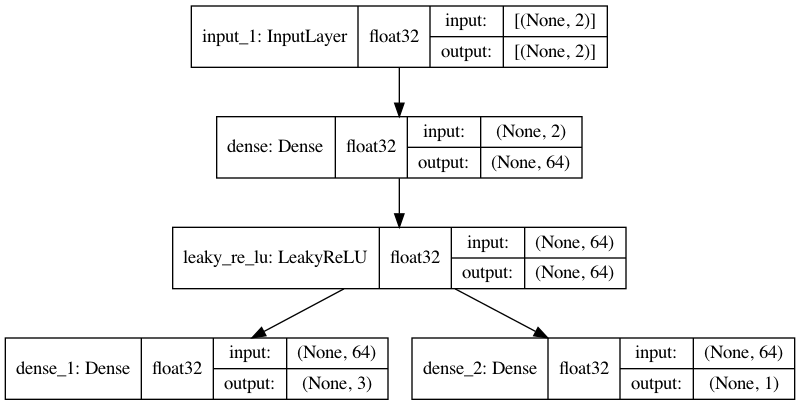

In [4]:
tf.keras.utils.plot_model(
    model,
#     to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [5]:
%%time
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
# action_probs_history = []
# critic_value_history = []
# rewards_history = []
running_reward = 0
episode_count = 0

proxy_running_reward = -200
episodes_sum_rewards = []
episodes_sum_proxy_rewards = []

i = 0
objectives = [-0.4, -0.3, -0.23, -0.2, -0.18, -0.16, -0.14, -0.12, -0.10, -0.08, -0.05, -0.02, 0.01, 0.05,
             0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
cur_obj_i = 0
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    stop_proxy_rewards = False
    
    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    proxy_rewards_history = []
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
        
            if not stop_proxy_rewards:
                # we track info only is the intermediate game is not won yet
                proxy_rewards_history.append(reward)
                action_probs_history.append(tf.math.log(action_probs[0, action]))
                critic_value_history.append(critic_value[0, 0])
                
            rewards_history.append(reward)
            if state[0] > objectives[cur_obj_i]:
                # we pretend it's over, i.e. the game is won and no more rewards after that
                stop_proxy_rewards = True 
            
            if done:
                break

        # Update running reward to check condition for solving
        # running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        episodes_sum_rewards.append(sum(rewards_history))
        episodes_sum_proxy_rewards.append(sum(proxy_rewards_history))
        running_reward = np.mean(episodes_sum_rewards[-100:])
#         proxy_running_reward = np.mean(episodes_sum_proxy_rewards[-10:])
        proxy_running_reward = 0.08 * sum(proxy_rewards_history) + (1 - 0.08) * proxy_running_reward
        
        if stop_proxy_rewards and not done:
            proxy_rewards_history[-1] += 100
        
        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
#         for r in rewards_history[::-1]:
        for r in proxy_rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
#         returns = np.array(returns)
#         returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
#         returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
#         action_probs_history.clear()
#         critic_value_history.clear()
#         rewards_history.clear()
#         proxy_rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "act running reward: {:.2f} at episode {} (proxy running reward: {})"
        print(template.format(running_reward, episode_count, round(proxy_running_reward, 4)))

    # MountainCar-v0 is considered "solved" when the agent obtains an average reward 
    # of at least -110.0 over 100 consecutive episodes
    if running_reward > -110:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
        
    if proxy_running_reward > -110:
        cur_obj_i += 1
        proxy_running_reward = -200
        print(f"update objective to: {objectives[cur_obj_i]}")
    
    i += 1
    if i == 10000:
        break

act running reward: -200.00 at episode 10 (proxy running reward: -178.8823)
act running reward: -200.00 at episode 20 (proxy running reward: -142.9315)
update objective to: -0.3
act running reward: -200.00 at episode 30 (proxy running reward: -200.0)
act running reward: -200.00 at episode 40 (proxy running reward: -180.098)
act running reward: -200.00 at episode 50 (proxy running reward: -142.1334)
act running reward: -200.00 at episode 60 (proxy running reward: -121.2782)
update objective to: -0.23
act running reward: -200.00 at episode 70 (proxy running reward: -183.5918)
act running reward: -200.00 at episode 80 (proxy running reward: -158.2613)
act running reward: -200.00 at episode 90 (proxy running reward: -163.9155)
act running reward: -200.00 at episode 100 (proxy running reward: -163.6634)
act running reward: -200.00 at episode 110 (proxy running reward: -145.5871)
act running reward: -200.00 at episode 120 (proxy running reward: -151.7194)
act running reward: -200.00 at episo

KeyboardInterrupt: 

In [ ]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
state = env.reset()

for i in range(1, 1000):
    env.render(); # Adding this line would show the attempts
    # of the agent in a pop up window.

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    # Predict action probabilities and estimated future rewards
    # from environment state
    action_probs, critic_value = model(state)

    # Sample action from action probability distribution
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))

    # Apply the sampled action in our environment
    state, reward, done, info = env.step(action)

    if done:
        print(i)
        break
env.close()

In [14]:
%%time
for i in range(100000000):
    a = i

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [7]:
done

True

In [8]:
state

array([-0.52166035,  0.01353652])

In [15]:
rewards_history

[-1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,

In [9]:
max_steps_per_episode

10000